# Making a 2D N-Body Simulation

##### PHYS 512 Final Project

In [1]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import imageio
#%matplotlib qt

#### Function to create the potential of a point charge

In [4]:
def point_charge_V(g, soft_r, b=5):
    x, y = np.meshgrid(np.linspace(-b,b, g+1), np.linspace(-b,b, g+1)) #2d meshgrid
    r = np.sqrt(x**2+y**2) #defining r (distance from particle)
    r[r<soft_r]=soft_r #softening
    V = 1/r #gravitational potential
    V=V[:-1,:-1] #getting rid of the extra gridcells
    return V

The above function creates a softened potential for a point charge. The softening is done by setting a limit on the minimum distance "r", which is called "soft r". What this does essentially is that if a distance is less than the soft r, the potential at that point is equal to the potential at soft r. This makes it so the 1/r function doesn't go off to infinity as r approaches 0, but rather plateaus.

I decided to create the density function with 1 more gridcell than what will be input in the nbody class. This is because I use even numbers for the number of gridcells, but if you create a point charge potential with an even number of gridcells, you don't obtain one central cell with maximum potential from which potential decreases with distance. Instead you get a 2x2 grid of max potential. This is a problem, because when the class will convolve the even point potential with the 2d density histogram, it will set one of the corners of the 2x2 cells on the cell for said point. When the gradient is then taken, the point will get affected by it's own potential, causing all the points to drift.

I could also just use an odd number of gridcells, but this was causing me issues (I think because of the fft and fftshift), so this was a solution that worked for me.

The difference between an even and odd number of gridcells for the point potential can be seen below:

<div>
Even:
<img src="images/other/even_point_V.png" width="500">
Odd:
<img src="images/other/odd_point_V.png" width="500">
</div>

#### The n-body class itself

In [5]:
class nbody:
    def __init__(self, n, gridcells, soft_r, x=False, m=False, v=False, periodic=True):
        self.n = n
        if x is False: #if no array for x is given, then initial positions are random
                        #numbers between 0 and 1 in x and y
            self.x = np.random.rand(n,2)
        else: #Making sure if you input an array for x, it has the proper shape
            if x.shape[1]!=2:
                print('Position must be a Nx2 array')
                assert(1==0)
            elif int(n)!=len(x):
                print("Number of particles doesn't match number of initial positions.")
                assert(1==0)
            self.x = x
        if m is False: #if no array for m is given, then all masses=1
            self.m = np.ones(n)
        else: #Making sure if you input an array for m, it has the proper shape
            if int(n)!=len(m):
                print("Number of particles doesn't match number of initial masses.")
                assert(1==0)
            self.m = m
        self.mstack = np.vstack((self.m,self.m)).T #used for energy calculation later
        if v is False: #if no array for v is given, all initial velocites = 0
            self.v = np.zeros([n,2])
        else: #Making sure if you input an array for v, it has the proper shape
            if v.shape[1]!=2:
                print('Position must be a Nx2 array')
                assert(1==0)
            elif len(x)!=len(v):
                print("Number of initial positions doesn't match number of initial velocities.")
                assert(1==0)
            self.v = v
        self.g = gridcells #number of gridcells per side
        self.soft = soft_r #softening radius
        self.periodic = periodic #If periodic or non-periodic bc
        self.pot = np.zeros([self.g,self.g]) #initialized for plotting purposes
        if periodic is True: #potential and fft of potential of point charge
            self.point = point_charge_V(self.g, self.soft)
            self.pointft = np.fft.rfft2(self.point)
        else: #potential and fft of potential of padded point charge
            self.point = point_charge_V(2*self.g, self.soft)            
            self.pointft = np.fft.rfft2(self.point)
            
        self.lostK = 0 #initialized for energy tracking with
        self.lostU = 0 #non-periodic boundary conditions
            
    def density(self, rk4=False):
        if rk4 is False: #Histogram of positions
            density = np.histogram2d(self.x[:,0],self.x[:,1], bins=self.g, weights=self.m, range=[[0,1],[0,1]])[0]
        else: #Histogram of input values used in rk4 step
            density = np.histogram2d(rk4[:,0],rk4[:,1], bins=self.g, weights=self.m, range=[[0,1],[0,1]])[0]

        if self.periodic is True:
            self.p = density
        else: #if non-periodic bc, need to pad the density with 0s
            self.p = np.zeros([self.g*2,self.g*2])
            self.p[self.g//2:3*self.g//2, self.g//2:3*self.g//2] = density
        return self.p
    
    def potential(self, rk4=False):
        if rk4 is False: #calling the density histogram
            density = self.density()
        else:
            density = self.density(rk4)
        
        densityft = np.fft.rfft2(density) #fft of density
        
        if self.periodic is True: #convolution of point potential and density histogram
            self.pot = np.fft.fftshift(np.fft.irfft2(densityft*self.pointft))
        else: #if non-periodic, padded zone needs to be cut out
            big = np.fft.fftshift(np.fft.irfft2(densityft*self.pointft))
            self.pot = big[self.g//2:3*self.g//2, self.g//2:3*self.g//2]
            
        return self.pot
    
    def force(self, rk4=False):
        if rk4 is False: #calling the potential of the system
            V = self.potential()
        else:
            V = self.potential(rk4)
        fx, fy = np.gradient(V) #gradient of potential in x & y
        dx = 1/self.g #length of each gridcell in x
        dy = 1/self.g #length of each gridcell in y
        self.f = np.empty([len(self.x),2]) #initializing force array
        for i in range(len(self.x)): #finding index in grid-space of each particle
            indx, indy = int(self.x[i,0]/dx), int(self.x[i,1]/dy)
            if indx == self.g: #if the particle is on the upper
                indx=indx-1    #boundary in x or y, bin it into
            if indy == self.g: #the gridcell before it
                indy=indy-1
            self.f[i] = np.array([fx[indx,indy],fy[indx,indy]])
            #force on each particle in x and y is gradient of potential in x &
            #y of the gridcell that the point falls into
        return self.f
    
    def leapfrog(self, dt):
        self.x=self.x+dt*self.v #update position
        if self.periodic is True: #in periodic bc, if the position exits the 
            for i in self.x:      #range, the particle simply re-enters the
                if i[0]>1:        #range on the opposite side
                    i[0]=i[0]-1
                if i[0]<0:
                    i[0]=i[0]+1
                if i[1]>1:
                    i[1]=i[1]-1
                if i[1]<0:
                    i[1]=i[1]+1
        else: #in non-periodic, points that leave the range are deleted from the system
            problems = [] #and the energy they had before leaving is kept in memory
            for i in range(len(self.x)): #to calculate the total energy of the system
                if self.x[i,0]>1 or self.x[i,1]>1 or self.x[i,0]<0 or self.x[i,1]<0:
                    problems.append(i)
            if len(problems)!=0:
                for i in problems:
                    self.lostK = self.lostK + np.sum(0.5*self.mstack[i]*self.v[i]**2)
                    self.lostU = self.lostU + np.sum(self.pot)/self.n
                self.x = np.delete(self.x, problems, 0)
                self.v = np.delete(self.v, problems, 0)
                self.m = np.delete(self.m, problems)
                self.mstack = np.delete(self.mstack, problems, 0)
        self.v=self.v+self.force()*dt #update velocity
        
    def get_derivs(self,xx): #used for rk4 step
        nn=xx.shape[0]//2
        x=xx[:nn,:] #break up xx back into position
        v=xx[nn:,:] #and velocity
        f=self.force(x) #calculate force on position
        return np.vstack([v,f]) #return verlocity and force
    
    def rk4(self, dt):
        xv = np.vstack([self.x,self.v]) #stack postition & velocity
        k1 = self.get_derivs(xv) #rk4 on position and velocity
        k2 = self.get_derivs(xv+k1*dt/2)
        k3 = self.get_derivs(xv+k2*dt/2)
        k4 = self.get_derivs(xv+k3*dt)
        
        tot=(k1+2*k2+2*k3+k4)/6
        v = tot[:len(self.x),:] #break up tot back into velocity
        f=tot[len(self.x):,:] #and force
        
        self.x = self.x + v*dt #update position
        if self.periodic is True: #same as in leapfrog for periodic bc
            for i in self.x:
                if i[0]>1:
                    i[0]=i[0]-1
                if i[0]<0:
                    i[0]=i[0]+1
                if i[1]>1:
                    i[1]=i[1]-1
                if i[1]<0:
                    i[1]=i[1]+1
        else: #and non-periodic bc
            problems = []
            for i in range(len(self.x)):
                if self.x[i,0]>1 or self.x[i,1]>1 or self.x[i,0]<0 or self.x[i,1]<0:
                    problems.append(i)
            if len(problems)!=0:
                for i in problems:
                    self.lostK = self.lostK + np.sum(0.5*self.mstack[i]*self.v[i]**2)
                    self.lostU = self.lostU + np.sum(self.pot)/self.n
                self.x = np.delete(self.x, problems, 0)
                self.v = np.delete(self.v, problems, 0)
                self.m = np.delete(self.m, problems)
                self.mstack = np.delete(self.mstack, problems, 0)
                f = np.delete(f, problems, 0)
        self.v = self.v + f*dt #update velocity

#### Explaining each function in the nbody class:
##### init:
The init function initializes the variables we will need for later. The nbody class itself takes in 7 parameters: the number of particles, the number of gridcells per side, the value for soft r, the initial position of each particle, the initial velocity of each particle, the mass of each particle and whether the boundary conditions are periodic or not. The initial postion, velocity and masses of each particle is an optional entry, and if none is specified, then x is created by generating n 2D random numbers between 0 and 1, v is set to 0 for each particle and m is set to 1 for each particle. Periodic is either true or false, if true, boundary conditions are periodic, if false, boundary conditions are non-periodic.

self.mstack is going to be used later for calculating kinetic energy, its just an nx2 array with each column being the mass vector.

self.pot is initialized so it can be called to plot the potential for the system later on. For now, the matrix is just set to 0.

At the end of the init function is the first divergence between the periodic and non-periodic boundary conditions. We want to generate our matrix for the point charge of a single particle, as well as the fft of said matrix to use later when convolving. For periodic boundary conditions, since the fourier transform itself is already a periodic function, we don't have to do any manipulations to our point charge potential. For non-periodic boundary conditions however, we have to make our point charge potential twice the size of the number of gricells. The reasoning for this will be explained below in the explanation for the density function.

In non-periodic boundary conditions, we also have to create 2 values to keep track of the kinetic and potential energy of lost particles, which is explained later in the leapfrog function.

##### density:
To create the density matrix, a 2D histogram is taken of the positions of all the particles. I chose to make the domain of my class [0,1] in both x and y, as it is easy to generate random numbers in this range using np.random.rand. The number of bins is set to the number of input gridcells, and the weights of each particle is set to the mass vector.

Here we see the first exception caused by our second step function: rk4. In leapfrog, we only ever need to find the density matrix of our particles, but in rk4, we need to take the density of values around the position of each particle, so we can't simply histogram self.x.

If we're using periodic boundary conditions, then our density matrix is done. If we're using non-periodic boundary conditions, we need to do a bit of padding.

So that the fft doesn't cause us periodic boundary conditions, we pad the density function with 0s in each direction equal in size to the original density matrix. This makes it so even when the fft wraps around, it will only see 0s on the other side, so the point won't feel a potential pulling it in that direction, which essentially makes it as if we cut it off and imposed a non-periodic system.

##### potential:
The potential function simply takes the density matrix and convolves it with the potential of a single point particle in order to obtain the potential of the entire system. The convolution is done by fourier transforming both the point particle potential and the density matrix, then multiplying them together and taking the inverse fourier transform.

Here again exceptions are needed if we use rk4 as our step.

If non-periodic boundary conditions are used, our potential matrix is 3 times the size we need it to be as it has been padded with 0s, so we need to pick out the area that will actually be needed from the padded potential.

##### force:
It's in the force function that the force on each particle is calculated. It receives as input the potential of the system and takes the gradient in both x and y. This gives us 2 grids with the force in x and y respectively on each gridcell, since force is equal to the gradient of potential. So now what we need to do is figure out in which gridcell each particle falls into. 

To do this, the total range (1 in this case) is divided by the number of gridcells in order to determine the size of each gridcell. The postition in x and y is then divided by this value to determine how many gridcells it takes to reach the particle. This in turn tells us the index in both x and y of the gridcell that a particle falls into. If the index is equal to the number of gridcells, the index is set to itself minus 1. This is done to include points falling on the outer boundary. For example, if you have 4 gridcells, then without this extra step, each gridcell would include particles falling in the following range: gc0=[0,0.25), gc1=[0.25,0.50), gc2=[0.50,0.75), gc3=[0.75,1). By adding this condition, we simply change it so now gc3=[0.75,1] to include particles falling on the top edge.

Once we know which gridcell each particle falls into, we set the force on that particle in x and y to the gradient in x and y of the potential at that same gridcell.

##### leapfrog:
Leapfrog is the function that actually takes a step. Leapfrog updates the position of each particle by adding v\*dt to it. It then checks to make sure particles haven't fallen outside of our range after taking their step. Once that check has been made, it calculates the new velocity of each particle by adding f*dt to it.

If particles have fallen out of the range in periodic boundary conditions, then all that needs to be done is to subtract the x or y position (whichever one has left the range) by 1 (the length of our range) in order to slot it back in on the other side of the range.

If we are using non-periodic boundary conditions, things are trickier. Following conservation of energy, particles under non-periodic boundary conditions should never be able to escape the range, however since our grid doesn't have an infinite number of gridcells and our dt isn't extremely tiny, some particles do end up escaping. If particles do escape, they are simply removed from the system, and the kinetic and potential energy they had before they left is retained. To estimate the potential energy of the particle that just left the system, the total potential is divided by the number of particles.

##### rk4 and get_derivs:
get_derivs is lumped in with rk4 here as it is only used when using rk4 as our step. In rk4, we use the runga-kutta method to estimate the new position of each particle, rather than using leapfrog. This method calculates the force on a particle in positions near the postition of the particle, then averages them to estimate the force on the particle. Just like the leapfrog function, the new position is calculated by adding v*dt to itself.

The get_derivs function intakes an array of both position and velocity, finds the force on each position, and returns an array of velocity and force.

The new velocity for each particle is calculated using this force by adding f*dt to itself.

Similarly to the leapfrog function, the rk4 function also has exceptions for particles that leave the range with both periodic and non-periodic boundary conditions.

#### A function created for plotting the particles

In [6]:
def plots(particles, nsteps, dt, step='leapfrog', savedir=False, Vplots=False, trackE=False):
    if step != 'leapfrog' and step !='rk4':
        print('Only permitted step mehtods are "leapfrog" and "rk4"')
        assert(1==0)
    plt.figure(figsize=(6,6))
    if savedir is not False:
        filenames = []
    if trackE is not False: #initializing tracking kinetic & potential energy
        K = np.zeros(nsteps)
        U = np.zeros(nsteps)
    if step =='leapfrog' and Vplots is not True:
        for i in range(nsteps):
            if trackE is not False: #calculate energy of system at each step
                K[i] = np.sum(0.5*particles.mstack*particles.v**2)+particles.lostK
                U[i] = np.sum(particles.potential(particles.x))+particles.lostU
            plt.clf()
            plt.plot(particles.x[:,0],particles.x[:,1],'.') #plot position
            plt.xlim(0,1)
            plt.ylim(0,1)
            plt.pause(0.001)
            particles.leapfrog(dt)
            if savedir is not False: #save images
                plt.savefig('{}/lf_{}.png'.format(savedir,i))
                filenames.append('lf_{}.png'.format(i))
        if savedir is not False: #created gif from saved images
            images = []
            for file in filenames:
                img = cv2.imread(os.path.join(savedir,file))
                images.append(img)
            imageio.mimsave('{}/leapfrog.gif'.format(savedir), images)
        
    if step =='leapfrog' and Vplots is True:
        for i in range(nsteps):
            if trackE is not False:
                K[i] = np.sum(0.5*particles.mstack*particles.v**2)+particles.lostK
                U[i] = np.sum(particles.potential(particles.x))+particles.lostU
            plt.clf()
            plt.pcolormesh(particles.pot.T)
            plt.pause(0.001)
            particles.leapfrog(dt)
            if savedir is not False:
                plt.savefig('{}/lf_V_{}.png'.format(savedir,i))
                filenames.append('lf_V_{}.png'.format(i))
        if savedir is not False:
            images = []
            for file in filenames:
                img = cv2.imread(os.path.join(savedir,file))
                images.append(img)
            imageio.mimsave('{}/leapfrog_V.gif'.format(savedir), images)
    
    if step =='rk4' and Vplots is not True:
        for i in range(nsteps):
            if trackE is not False:
                K[i] = np.sum(0.5*particles.mstack*particles.v**2)+particles.lostK
                U[i] = np.sum(particles.potential(particles.x))+particles.lostU
            plt.clf()
            plt.plot(particles.x[:,0],particles.x[:,1],'.')
            plt.xlim(0,1)
            plt.ylim(0,1)
            plt.pause(0.001)
            particles.rk4(dt)
            if savedir is not False:
                plt.savefig('{}/rk4_{}.png'.format(savedir,i))
                filenames.append('rk4_{}.png'.format(i))
        if savedir is not False:
            images = []
            for file in filenames:
                img = cv2.imread(os.path.join(savedir,file))
                images.append(img)
            imageio.mimsave('{}/rk4.gif'.format(savedir), images)
    
    if step =='rk4' and Vplots is True:
        for i in range(nsteps):
            if trackE is not False:
                K[i] = np.sum(0.5*particles.mstack*particles.v**2)+particles.lostK
                U[i] = np.sum(particles.potential(particles.x))+particles.lostU
            plt.clf()
            plt.pcolormesh(particles.potential(particles.x).T)
            plt.pause(0.001)
            particles.rk4(dt)
            if savedir is not False:
                plt.savefig('{}/rk4_V_{}.png'.format(savedir,i))
                filenames.append('rk4_V_{}.png'.format(i))
        if savedir is not False:
            images = []
            for file in filenames:
                img = cv2.imread(os.path.join(savedir,file))
                images.append(img)
            imageio.mimsave('{}/rk4_V.gif'.format(savedir), images)
    if trackE is not False:
        return K, U, K+U

The above function takes in a class of particles, the number of steps we want to take, dt, as well as which step function to use. There is also a parameter which allows you to save each plot in order to create a gif of the evolution of particle positions with time. The option to view plots of the potential of the system rather than the position of each particle as well as track the energy of the system is also possible using the extra parameters.

The function plots the position (or the potential of the system if that's what's selected) of each particle in the system, then takes a step (in either leapfrog or rk4 with a set dt), then plots the position again, then takes another step... and so on.

If the energy is wished to be tracked, then at each step the kinetic energy of the system is calculated using $K = \frac{1}{2}mv^2$ and the potential energy is calculated by summing up the total potential in the system. If non-periodic boundary conditions are being used, then the kinetic and potential energy of particles that have left the system has to be added to these values.

### Part 1:

In [7]:
parts = nbody(1, 200, 0.5, periodic=True)
plots(parts, 50, 0.005, step='leapfrog', savedir='images/particle_at_rest')

<div>
<img src="images/particle_at_rest/leapfrog.gif" width="400">
</div>

As can be seen in the super interesting gif above, a single particle starting at rest remains motionless.

### Part 2:

In [8]:
circlex = np.array([[0.4,0.5],[0.6,0.5]])
circlev = np.array([[0,0.05],[0,-0.05]])

parts=nbody(2,200,0.5, x=circlex, v=circlev, periodic=False)
plots(parts, 500, 0.05, step='leapfrog', savedir='images/rotate')

<div>
<img src="images/rotate/leapfrog.gif" width="400">
</div>

As you can see, two particles placed in a circular orbit continue to orbit eachother. And if you don't believe me that they follow a circular path, we can plot their trails too:

<div>
<img src="images/rotate_save/leapfrog.gif" width="400">
</div>

### Problem 3:

The systems for problem 3 and 4 were run on a different computer, but these where the settings used for it.

In [9]:
nparts = 500000
nsteps = 1500
gridcells = 200
soft = 0.5
dt = 0.0005

Below are the position and potential plots using leapfrog as our step and with non-periodic boundary conditions.

<div>
<img src="images/leapfrog/leapfrog_non.gif" width="400">
</div>

<div>
<img src="images/leapfrog/leapfrog_V_non.gif" width="400">
</div>

In [2]:
K_leap_non = np.loadtxt('images/leapfrog/K_leap_non.txt')
U_leap_non = np.loadtxt('images/leapfrog/U_leap_non.txt')
E_leap_non = np.loadtxt('images/leapfrog/E_leap_non.txt')

Below are the position and potential plots using leapfrog as our step and with periodic boundary conditions.

<div>
<img src="images/leapfrog/leapfrog_period.gif" width="400">
</div>

<div>
<img src="images/leapfrog/leapfrog_V_period.gif" width="400">
</div>

In [3]:
K_leap_period = np.loadtxt('images/leapfrog/K_leap_period.txt')
U_leap_period = np.loadtxt('images/leapfrog/U_leap_period.txt')
E_leap_period = np.loadtxt('images/leapfrog/E_leap_period.txt')

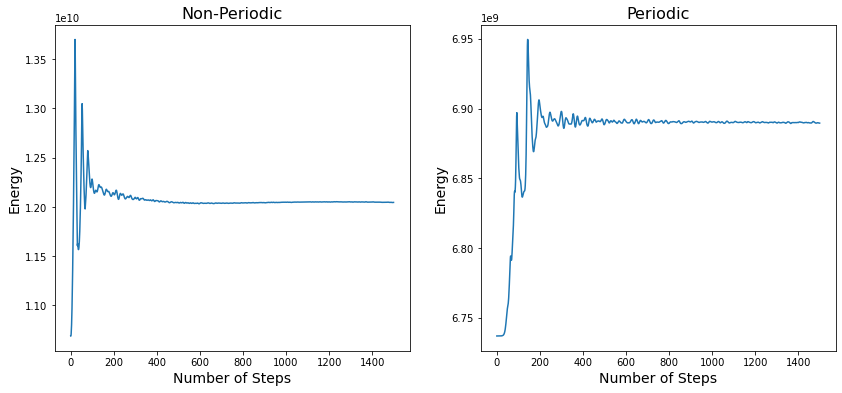

In [7]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title('Non-Periodic', fontsize=16)
plt.plot(E_leap_non)
plt.xlabel('Number of Steps', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.subplot(1,2,2)
plt.title('Periodic', fontsize=16)
plt.plot(E_leap_period)
plt.xlabel('Number of Steps', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.show()

As can be seen from the above graphs, the non-periodic boundary conditions stabilizes faster and remains more stable than when using periodic boundary conditions. The fact that many particles end up leaving the range and so get deleted from the system however means that there is more estimation in the non-periodic boundary conditions, and so the result may be less accurate.

Based on these results, it seems that, when using leapfrog as our step, the non-periodic boundary conditions preserve energy better than the periodic boundary conditions.

### Problem 4:

The only difference in parameters between problems 3 and 4 is that the number of steps for our rk4 system was divided by 4, since each step calls our force function 4 times.

Below are the position and potential plots using rk4 as our step and with non-periodic boundary conditions.

<div>
<img src="images/rk4/rk4_non.gif" width="400">
</div>

<div>
<img src="images/rk4/rk4_V_non.gif" width="400">
</div>

In [8]:
K_rk4_non = np.loadtxt('images/rk4/K_rk4_non.txt')
U_rk4_non = np.loadtxt('images/rk4/U_rk4_non.txt')
E_rk4_non = np.loadtxt('images/rk4/E_rk4_non.txt')

Below are the position and potential plots using rk4 as our step and with periodic boundary conditions.

<div>
<img src="images/rk4/rk4_period.gif" width="400">
</div>

<div>
<img src="images/rk4/rk4_V_period.gif" width="400">
</div>

In [9]:
K_rk4_period = np.loadtxt('images/rk4/K_rk4_period.txt')
U_rk4_period = np.loadtxt('images/rk4/U_rk4_period.txt')
E_rk4_period = np.loadtxt('images/rk4/E_rk4_period.txt')

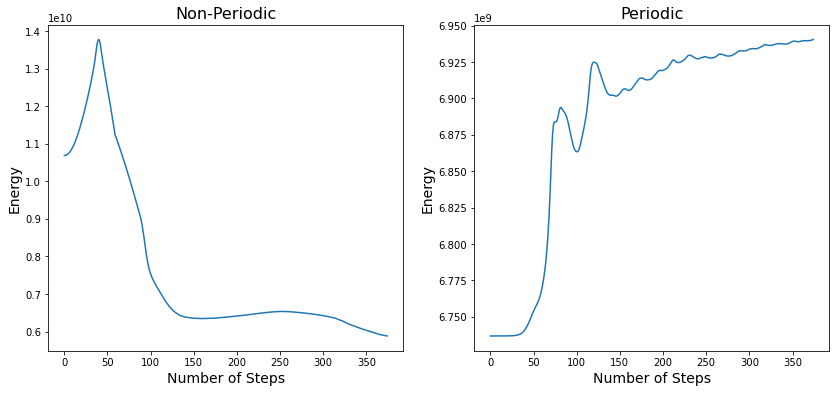

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title('Non-Periodic', fontsize=16)
plt.plot(E_rk4_non)
plt.xlabel('Number of Steps', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.subplot(1,2,2)
plt.title('Periodic', fontsize=16)
plt.plot(E_rk4_period)
plt.xlabel('Number of Steps', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.show()

This is not at all what I was expecting from using rk4 as the step. The energy in both periodic and non-periodic boundary conditions doesn't seem to stabilize. Granted, this system only takes a quarter of the steps that leapfrog takes, but based on when I've used rk4 in the past, it still usually would get a better result despite the lower number of steps.

Unexpectedly, based on these results, using leapfrog as our step actually preserves energy better than using rk4 at fixed computational work time.